## Data Collection

In [1]:
# !tar xf IAM_Words\words.tgz -C data\words
# !move IAM_Words\words.txt data

## Libraries

In [17]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from keras.layers import Input, MaxPooling2D, Conv2D, Reshape, Dense, Dropout
from keras.layers import Bidirectional, LSTM
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Data PreProcessing / Augmentation

### data split

In [4]:
word_list = []

words = open(f"data/words.txt","r").readlines()
for line in words:
    if line[0] == '#':
        continue
    if line.split(" ")[1] != "err":
        word_list.append(line)
    
print(len(word_list))
np.random.shuffle(word_list)

96456


In [5]:
split = int(0.9 * len(word_list))
train_data = word_list[:split]
test_data = word_list[split:]
val_split = int(0.5 * len(word_list))
val_data = word_list[:val_split]
test_data = word_list[val_split:]

# assert len(word_list) == len(train_data) + len(val_data) + len(test_data)

print("Total training samples:",len(train_data))
print("Total validation samples:", len(val_data))
print("Total test samples:", len(test_data))

Total training samples: 86810
Total validation samples: 48228
Total test samples: 48228


### data input pipeline

In [6]:
base_image_path = os.path.join(r'data/words')

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for i, file_line in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        image_name = line_split[0]
        part1 = image_name.split("-")[0]
        part2 = image_name.split("-")[1]
        img_path = os.path.join(base_image_path, part1, part1 + "-" + part2, image_name + ".png")
        
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])
            
    return paths, corrected_samples

In [7]:
train_img_paths, train_labels = get_image_paths_and_labels(train_data)
val_img_paths, val_labels = get_image_paths_and_labels(val_data)
test_img_paths, test_labels = get_image_paths_and_labels(test_data)

#### data cleaning

In [8]:
train_labels_cleaned = []
characters = set()
max_len = 0
for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)
        
    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)
    
print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [9]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    
    return cleaned_labels

val_labels_cleaned = clean_labels(val_labels)
test_labels_cleaned = clean_labels(test_labels)

#### building vocabulary

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

char_to_num = StringLookup(vocabulary = list(characters), mask_token = None)

num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

#### resizing images

In [11]:
def distortion_free_resize(image, img_size):
    w,h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio = True)
    
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]
    
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
        
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2
        
    image = tf.pad(image, paddings = [[pad_height_top, pad_height_bottom],[pad_width_left, pad_width_right],[0, 0]])
    
    image = tf.transpose(image, perm = [1, 0, 2])
    image = tf.image.flip_left_right(image)
    
    return image

## Initialize

In [12]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size = (image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding = "UTF-8"))
    length = tf.shape(label)[0]
    pad_ammount = max_len - length
    label = tf.pad(label, paddings = [[0, pad_ammount]], constant_values = padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls = AUTOTUNE)
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [13]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(val_img_paths, val_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

### samples

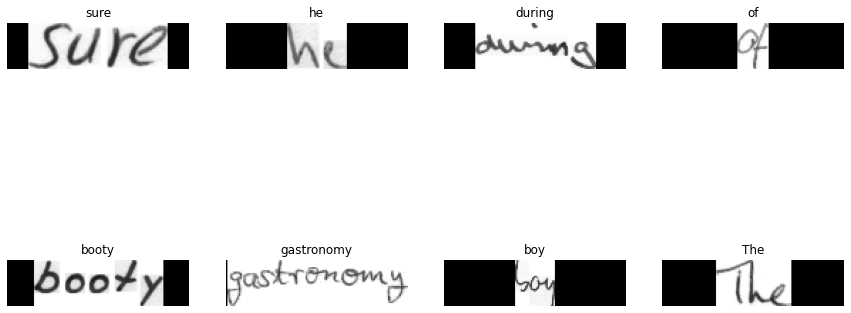

In [14]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(2, 4, figsize=(15, 8))

    for i in range(8):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))

        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

## Model

In [25]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        input_length *= tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length *= tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred
    
def build_model():
    input_img =Input(shape = (image_width, image_height, 1), name = "Image")
    labels = Input(name="label", shape = (None,))

    x = Conv2D(32,
            (3,3),
            activation="relu",
            kernel_initializer = "he_normal",
            padding = "same",
            name = "Conv1")(input_img)

    x = MaxPooling2D((2,2), name = "pool1")(x)

    x = Conv2D(64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv2")(x)

    x = MaxPooling2D((2, 2), name="pool2")(x)
    new_shape = ((image_width//4), (image_height // 4) * 64)
    x = Reshape(target_shape = new_shape, name="reshape")(x)
    x = Dense(64, activation = "relu", name="dense1")(x)
    x = Dropout(0.2)(x)

    x = Bidirectional(LSTM(128, return_sequences = True, dropout = 0.25))(x)
    x = Bidirectional(LSTM(64, return_sequences = True, dropout = 0.25))(x)
    x = Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name = "dense2")(x)
    output = CTCLayer(name = "ctc_loss")(labels, x)
    model = Model(inputs = [input_img, labels], outputs = output, name="handRec")
    model.compile(optimizer=["Adam"])
    return model

model = build_model()
model.summary()

Model: "handRec"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['Image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0]']            

## Edit Distance

In [26]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])